## Imports

In [ ]:

import pandas as pd
import numpy as np

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saifu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saifu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Saifu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Load the dataset
df = pd.read_csv('Datasets/train_data (1).csv')

In [3]:
df.columns = ['review', 'sentiment']  # Rename columns for clarity
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (25000, 2)


,review,sentiment
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


# Function to clean text

### Function

In [20]:
# Function to clean text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

### Applying clean text function

In [21]:
# Apply cleaning to the review column
df['clean_review'] = df['review'].apply(clean_text)

In [22]:
# Show cleaned data
df[['review', 'clean_review', 'sentiment']].head()

,review,clean_review,sentiment
0,"This film is absolutely awful, but nevertheles...",film absolutely awful nevertheless hilarious t...,0
1,Well since seeing part's 1 through 3 I can hon...,well since seeing parts honestly say never mad...,0
2,I got to see this film at a preview and was da...,got see film preview dazzled typical romantic ...,1
3,This adaptation positively butchers a classic ...,adaptation positively butchers classic beloved...,0
4,Råzone is an awful movie! It is so simple. It ...,rzone awful movie simple seems tried make movi...,0


### Save the Cleaned data as csv file

In [23]:
# Save cleaned data to CSV
df.to_csv('Datasets/cleaned_train_data.csv', index=False)
print('Cleaned data saved as Datasets/cleaned_train_data.csv')

Cleaned data saved as Datasets/cleaned_train_data.csv


# Split Dataset

In [24]:
# Split into train (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])
print('Train shape:', train_df.shape, 'Test shape:', test_df.shape)

Train shape: (20000, 3) Test shape: (5000, 3)


In [25]:
# Use the cleaned reviews for modeling
X_train = train_df['clean_review']
y_train = train_df['sentiment']
X_test = test_df['clean_review']
y_test = test_df['sentiment']

# Model Trainings

In [26]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [71]:
# Save the fitted TF-IDF vectorizer
joblib.dump(tfidf, './Models/tfidf_vectorizer.pkl')
print('TF-IDF vectorizer saved as ./Models/tfidf_vectorizer.pkl')

TF-IDF vectorizer saved as ./Models/tfidf_vectorizer.pkl


## Use Logistic Regression

In [27]:
# Train Logistic Regression model
model = LogisticRegression(max_iter=200)    
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [30]:
# Predict on test set
y_pred = model.predict(X_test_tfidf)


### Evaluation

In [13]:
# Step 3: Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8878
Precision: 0.8830501777953378
Recall: 0.894
F1-score: 0.8884913536076327

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      2500
           1       0.88      0.89      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



### Confusion Matrix

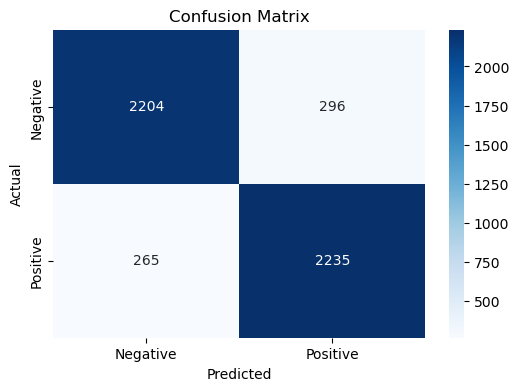

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Save the model

In [32]:
# Save Logistic Regression model
joblib.dump(model, './Models/logistic_regression_model.pkl')
print('Logistic Regression model saved as logistic_regression_model.pkl')

Logistic Regression model saved as logistic_regression_model.pkl


## Use Naive Bayes Classifier

### Naive Bayes model Training

In [33]:

# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)



MultinomialNB()

### Evaluation

In [34]:
# Predict on test set with Naive Bayes
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluation for Naive Bayes
print('Naive Bayes Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Precision:', precision_score(y_test, y_pred_nb))
print('Recall:', recall_score(y_test, y_pred_nb))
print('F1-score:', f1_score(y_test, y_pred_nb))
print('\nClassification Report:\n', classification_report(y_test, y_pred_nb))

Naive Bayes Results:
Accuracy: 0.8606
Precision: 0.8742216687422167
Recall: 0.8424
F1-score: 0.858015889183133

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      2500
           1       0.87      0.84      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



### Confusion Matrix

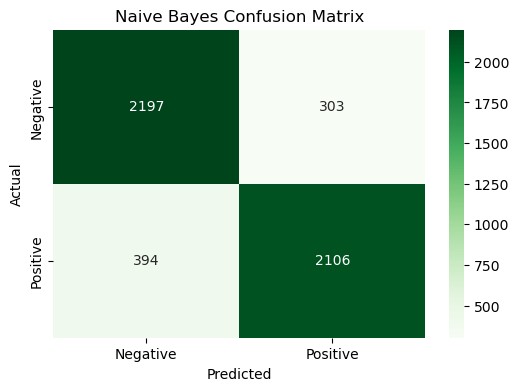

In [35]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

### Save the models

In [36]:
# Save Naive Bayes model
joblib.dump(nb_model, './Models/naive_bayes_model.pkl')
print('Naive Bayes model saved as naive_bayes_model.pkl')


Naive Bayes model saved as naive_bayes_model.pkl


## use LSTM (Bonus)

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Tokenize and Padding

In [74]:
# Parameters
max_words = 10000
max_len = 250
embedding_dim = 200

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

### LSTM Architecture

In [75]:
# Build the LSTM model
model_lstm = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\Saifu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [76]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


In [65]:
model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [77]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [78]:
# Train
history = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 233ms/step - accuracy: 0.7220 - loss: 0.5433 - val_accuracy: 0.8794 - val_loss: 0.2989 - learning_rate: 5.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 231ms/step - accuracy: 0.9244 - loss: 0.2159 - val_accuracy: 0.8790 - val_loss: 0.3004 - learning_rate: 5.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - accuracy: 0.9534 - loss: 0.1465 - val_accuracy: 0.8732 - val_loss: 0.3444 - learning_rate: 5.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 213ms/step - accuracy: 0.9734 - loss: 0.0882 - val_accuracy: 0.8706 - val_loss: 0.3939 - learning_rate: 2.5000e-04


### Evaluation

In [79]:
# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f'LSTM Test Accuracy: {accuracy:.4f}')

# Predict and classification report
y_pred_dl = (model_lstm.predict(X_test_pad) > 0.5).astype('int32')
print('LSTM Classification Report:\n', classification_report(y_test, y_pred_dl))

LSTM Test Accuracy: 0.8794
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2500
           1       0.89      0.87      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### Confusion Matrix

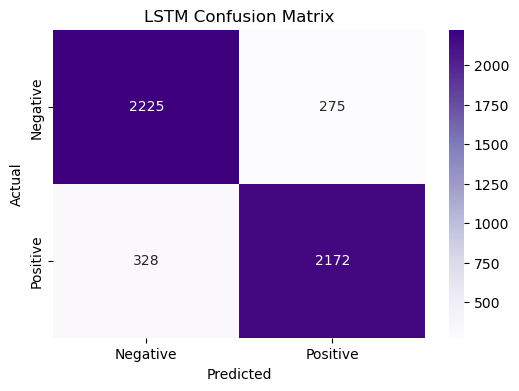

In [80]:
# Confusion Matrix for LSTM model
from sklearn.metrics import confusion_matrix
cm_lstm = confusion_matrix(y_test, y_pred_dl)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

### Save the model

In [81]:
# Save the trained LSTM model as a pickle (.pkl) file
joblib.dump(model_lstm, './Models/lstm_model.pkl')
print('LSTM model saved as ./Models/lstm_model.pkl')

LSTM model saved as ./Models/lstm_model.pkl
